In [ ]:
!pip install pandas

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.5 MB 3.5 MB/s eta 0:00:04
   -- ------------------------------------- 0.8/11.5 MB 3.5 MB/s eta 0:00:04
   -- ------------------------------------- 0.8/11.5 MB 3.5 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/11.5 MB 1.5 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/11.5 MB 1.5 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/11.5 MB 1.1 MB/s eta 0:00:10
   ---- ----------------------------------- 1.3/11.5 MB 1.1 MB/s eta 0:00:10
   ----- ---------------------------------- 1.6/11.5 MB 876.6 kB/s eta 0:00:12
   ------ --------------------------------- 1.8/11.5 MB 924.1 kB/s eta 0:00:11
   --------- ------------------------------ 2.6/11.5 MB 1.2 MB/s eta 0:00:08
   ---------- ----------------------------- 3.1/11.5 MB 1.3 MB/s eta 0:00:07
   ------------ --------------------------- 3.7/11.5 MB 1.5 MB/s eta 0:00:06
  

In [ ]:
!pip install numpy

In [ ]:
!pip install scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.0 MB 7.7 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/11.0 MB 10.1 MB/s eta 0:00:01
   --------- ------------------------------ 2.6/11.0 MB 4.8 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/11.0 MB 3.8 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/11.0 MB 3.6 MB/s eta 0:00:03
   --------------- ------------------------ 4.2/11.0 MB 3.4 MB/s eta 0:00:02
   ------------------ --------------------- 5.0/11.0 MB 3.5 MB/s eta 0:00:02
   --------------------- ------------------ 5.8/11.0 MB 3.6 MB/s eta 0:00:02
   ----------------------- ---------------- 6.6/11.0 MB 3.6 MB/s eta 0:00:02
   --------------------------- ------------ 7.6/11.0 MB 3.7 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 4.0 MB/s eta 0:00:01
   ------------------------------------- -- 10.2/11.0 MB 4.2 MB/s eta 0:00:01
   -

In [ ]:
!pip install matplotlib

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 3.9 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/7.8 MB 5.0 MB/s eta 0:00:02
   ----------------- ---------------------- 3.4/7.8 MB 6.0 MB/s eta 0:00:01
   ---------------------------- ----------- 5.5/7.8 MB 7.2 MB/s eta 0:00:01
   -------------------------------------- - 7.6/7.8 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 7.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------------------------------- - 2.1/2.2 MB 10.8 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 10.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   -------------------------------- ------- 2.1/2.6 MB 10.8 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 10.4 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
def classify_vehicle(static_time, velocity):
    if static_time > 100 or velocity < 5:
        return 'high'
    elif 5 <= velocity <= 10 and 50 <= static_time <= 100:
        return 'medium'
    else:
        return 'low'

In [4]:
def classify_traffic(vehicle_count, vehicle_frequency):
    if vehicle_count >= 50 and vehicle_frequency == 'high':
        return 'high'
    elif 4 <= vehicle_count < 50 and vehicle_frequency == 'high':
        return 'high'
    elif vehicle_count < 4 and vehicle_frequency == 'high':
        return 'medium'
    elif vehicle_count >= 50 and vehicle_frequency == 'medium':
        return 'medium'
    elif 25 <= vehicle_count < 50 and vehicle_frequency == 'medium':
        return 'medium'
    elif vehicle_count < 25 and vehicle_frequency == 'medium':
        return 'low'
    if vehicle_count >= 50 and vehicle_frequency == 'low':
        return 'low'
    elif 25 <= vehicle_count < 50 and vehicle_frequency == 'low':
        return 'low'
    elif vehicle_count < 25 and vehicle_frequency == 'low':
        return 'low'
    else:
        return 'low'

In [5]:
def load_data_for_lstm(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dataframes = []
    location_sno_counts = {}

    for file in all_files:
        try:
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            for index, row in df.iterrows():
                location = row['Location']
                sno = row['S.no']
                key = (sno, location)

                if key not in location_sno_counts:
                    location_sno_counts[key] = 1
                else:
                    location_sno_counts[key] += 1

        except Exception as e:
            print(f"Error processing {file} in counting pass: {e}")

    for file in all_files:
        try:
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            current_location = None
            start_index = 0
            df['traffic_frequency'] = ''

            for index, row in df.iterrows():
                if current_location is None or row['Location'] != current_location or row['S.no'] != df.at[start_index, 'S.no']:
                    if current_location is not None:
                        key = (df.at[start_index, 'S.no'], current_location)
                        vehicle_count = location_sno_counts.get(key, 0)
                        df.loc[start_index:index - 1, 'traffic_frequency'] = classify_traffic(vehicle_count, last_vehicle_frequency)

                    current_location = row['Location']
                    start_index = index

                vehicle_frequency = classify_vehicle(row['Static Time (s)'], row['Velocity (m/sec)'])
                df.at[index, 'vehicle_frequency'] = vehicle_frequency
                last_vehicle_frequency = vehicle_frequency

            if current_location is not None:
                key = (df.at[start_index, 'S.no'], current_location)
                vehicle_count = location_sno_counts.get(key, 0)
                df.loc[start_index:, 'traffic_frequency'] = classify_traffic(vehicle_count, last_vehicle_frequency)

            selected_columns = ["S.no", "Owner", "License Plate", "Current Route", "Location", "Distance (m)", "Time", "Static Time (s)", "Total Time (s)", "Velocity (m/sec)", "Previous Hash", "Hash", "vehicle is in traffic (y/n)", "vehicle_frequency", "traffic_frequency"]
            df = df[selected_columns]

            if not df.empty:
                dataframes.append(df)

            df.to_csv(file_path, index=False)

        except Exception as e:
            print(f"Error processing {file}: {e}")

    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

In [6]:
folder_path = r'C:\Users\vivek\OneDrive\Desktop\Mhmm\data'
df = load_data_for_lstm(folder_path)

In [7]:
df.head()

,S.no,Owner,License Plate,Current Route,Location,Distance (m),Time,Static Time (s),Total Time (s),Velocity (m/sec),Previous Hash,Hash,vehicle is in traffic (y/n),vehicle_frequency,traffic_frequency
0,1,0x103,ABC732,RouteD,LocationM,55000,1.731923e+09,36,3934,13.980681,0000000000000000000000000000000000000000000000...,ffb9c64f3e2d7c54bb6c5d75e88dca47dfc4553aa1b84d...,False,low,low
1,2,0x103,ABC732,RouteD,LocationN,55000,1.731923e+09,93,5657,9.722468,ffb9c64f3e2d7c54bb6c5d75e88dca47dfc4553aa1b84d...,6c0b17da8cf10853ae473f3d7e18a54ae129fc72e0896b...,False,medium,medium
2,3,0x103,ABC732,RouteD,LocationO,55000,1.731923e+09,70,7265,7.570544,6c0b17da8cf10853ae473f3d7e18a54ae129fc72e0896b...,8d12aa140a3c01020f0f78d6f466590b2b51aca3559655...,False,medium,medium
3,4,0x103,ABC732,RouteD,LocationP,55000,1.731923e+09,86,9636,5.707763,8d12aa140a3c01020f0f78d6f466590b2b51aca3559655...,528540597d4756ed7b24eb6e8cc8d7a64e5daa7e4d04a0...,False,medium,medium
4,5,0x103,ABC732,RouteD,LocationQ,55000,1.731923e+09,99,11525,4.772234,528540597d4756ed7b24eb6e8cc8d7a64e5daa7e4d04a0...,17c8165ec33ed467dc1560039d4a4ce2871759ad683c93...,False,high,high


In [8]:
len(df)

116009

In [9]:
route_distances = {
    "RouteA": (22000, ("LocationA", "LocationB", "LocationC", "LocationD")),
    "RouteB": (7000, ("LocationE", "LocationF", "LocationG")),
    "RouteC": (40000, ("LocationH", "LocationI", "LocationJ", "LocationK", "LocationL")),
    "RouteD": (55000, ("LocationM", "LocationN", "LocationO", "LocationP", "LocationQ", "LocationR")),
}

In [10]:
def extract_last_location_rows(df, route_distances):
    last_location_rows = pd.DataFrame()

    if 'Location' not in df.columns:
        return last_location_rows

    for route, (_, locations) in route_distances.items():
        last_location = locations[-1]
        route_rows = df[df['Location'].str.strip() == last_location]

        if route_rows.empty:
            print(f"No data found for last location '{last_location}'.")
        else:
            last_location_rows = pd.concat([last_location_rows, route_rows])

    last_location_rows = last_location_rows.sort_values(by=['S.no']).reset_index(drop=True)

    return last_location_rows

In [11]:
last_location_df = extract_last_location_rows(df, route_distances)

In [12]:
last_location_df.head()

,S.no,Owner,License Plate,Current Route,Location,Distance (m),Time,Static Time (s),Total Time (s),Velocity (m/sec),Previous Hash,Hash,vehicle is in traffic (y/n),vehicle_frequency,traffic_frequency
0,3,0x713,ABC780,RouteB,LocationG,7000,1.731923e+09,90,6198,1.129397,0b6e92d33740138e0b3a16df94defb3dee4db9b2a4c56e...,cdc63acacc64de625f346bb2ca538d444417d800177db2...,False,high,high
1,3,0x586,ABC890,RouteB,LocationG,7000,1.731923e+09,101,7009,0.998716,49af464c5a885c96d222b8e6a4ab8e6c78602390142703...,9f6cccb5991eede0eb21001a1ec23ea8160b8763378a4d...,True,high,high
2,3,0x342,ABC225,RouteB,LocationG,7000,1.731923e+09,125,6171,1.134338,a59c27eba014c053ee96f270d04939d82a7161d1069710...,46f58072db7d0112f811689e9c935ea19003db2b91318f...,True,high,high
3,3,0x111,ABC569,RouteB,LocationG,7000,1.731923e+09,56,7067,0.990519,83b5d91e5e56eb35ec0859e01daf3e49d982a83f61eb32...,a2ae9c015eaa572d2821d1e3d63ae92a50c57ebb0fcf47...,False,high,high
4,3,0x599,ABC211,RouteB,LocationG,7000,1.731923e+09,31,6156,1.137102,d3df9780260f2b3a379ab8ca241ab45d7153aa8cfc9c34...,3a6e353aea79afaf05a31b5ac57746b616f2f70b1d19dd...,False,high,high


In [13]:
last_location_df.to_csv("last_location_df.csv", index=False)

### Data Preprocessing

In [14]:
features = ["Distance (m)", "Time", "Static Time (s)", "Total Time (s)", "Velocity (m/sec)", "vehicle_frequency", "traffic_frequency"]
df_1 = last_location_df[features].copy()

encoder = LabelEncoder()
df_1['vehicle_frequency'] = encoder.fit_transform(df_1['vehicle_frequency'])
df_1['traffic_frequency'] = encoder.fit_transform(df_1['traffic_frequency'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_1)

X = scaled_data[:, :-1]
y = scaled_data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Reshape the Data for LSTM (3D array)

In [16]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### LSTM Model

In [21]:
model = Sequential()
model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid')) 

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\vivek\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Train the Model

In [22]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8707 - loss: 0.4743 - val_accuracy: 0.9429 - val_loss: 0.1544
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9446 - loss: 0.1314 - val_accuracy: 0.9622 - val_loss: 0.1080
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9610 - loss: 0.0999 - val_accuracy: 0.9638 - val_loss: 0.1041
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9629 - loss: 0.1006 - val_accuracy: 0.9574 - val_loss: 0.1006
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9635 - loss: 0.0989 - val_accuracy: 0.9595 - val_loss: 0.0980
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9658 - loss: 0.0932 - val_accuracy: 0.9636 - val_loss: 0.0948
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9637 - loss: 0.0985 - val_accuracy: 0.9634 - val_loss: 0.0906
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9643 - loss: 0.0923 - val_accuracy: 0.

### Evaluate the Model

In [23]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

646/646 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.9673 - loss: 0.0799
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.9652 - loss: 0.0825
Test Accuracy: 96.69%


### Plot Accuracy and Loss

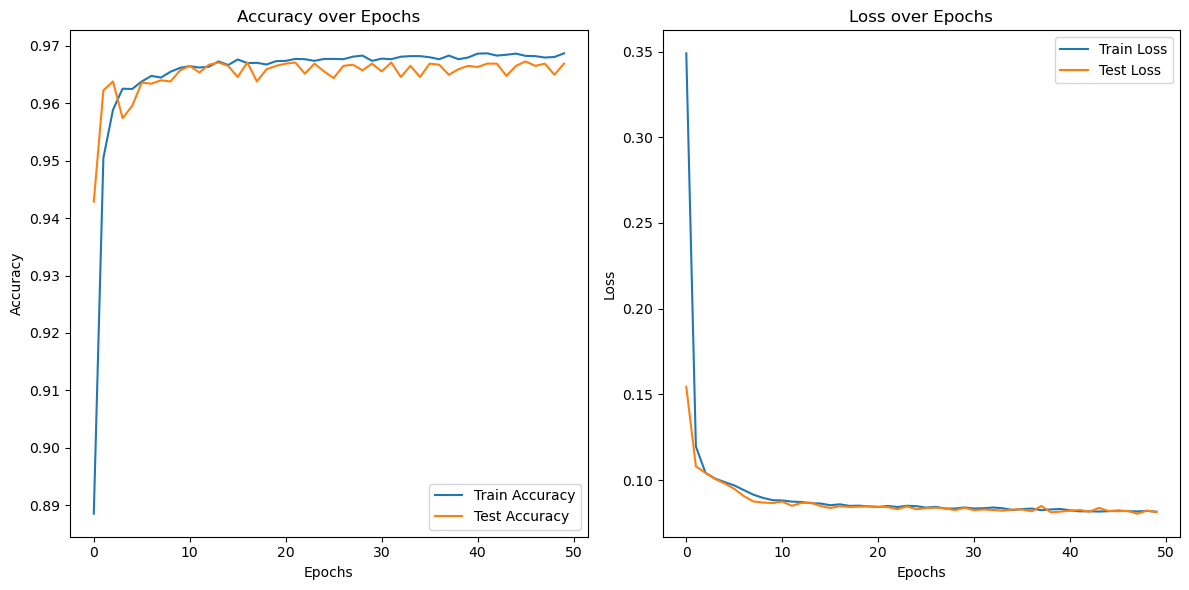

In [24]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Predict the Best Route

In [25]:
last_location_df = last_location_df.reset_index(drop=True)
y_pred = model.predict(X_test).ravel()
y_pred_label = encoder.inverse_transform((y_pred > 0.5).astype(int))

best_location_time = last_location_df.loc[np.argmin(y_pred_label), ['Location', 'Total Time (s)']]
best_location = best_location_time['Location']
best_total_time = best_location_time['Total Time (s)']
print(f"The predicted best Location is: {best_location}")

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
The predicted best Location is: LocationG


In [26]:
best_route = None
for route, (distance, locations) in route_distances.items():
    if best_location in locations:
        best_route = route
        Distance = distance
        break

print(f"The best Route is: {best_route}")
print(f"Distance is: {Distance} meters")
print(f"Total Time taken: {best_total_time} seconds")

The best Route is: RouteB
Distance is: 7000 meters
Total Time taken: 6198 seconds


In [27]:
if 'Total Time (s)' in last_location_df.columns:
    time_check = last_location_df[last_location_df['Total Time (s)'] <= 6198]

    if not time_check.empty:
        time_check.to_csv("rows_with_time_less_than_6198.csv", index=False)
    else:
        print("non")
else:
    print("NA")